# 09__cis_trans_interactions

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def is_ctrl(row):
    if "CONTROL" in row["index"]:
        return "control"
    else:
        return "TSS"

In [5]:
def cis_trans_int_status(row):
    if row.fdr < 0.1:
        return "significant cis/trans interaction"
    else:
        return "no cis/trans interaction"

In [6]:
def cis_trans_int_status_detail(row):
    if row.fdr < 0.1:
        if row.logFC < 0:
            return "cis effect\n(higher in human)"
        else:
            return "cis effect\n(higher in mouse)"
    else:
        return "no cis effect"

## variables

In [7]:
results_dir = "../../../data/02__mpra/03__results"
results_f = "%s/native_cis_trans_effects_data.txt" % results_dir

In [8]:
data_dir = "../../../data/02__mpra/02__activs"
cis_trans_int_f = "%s/cis_trans_interaction_results.txt" % data_dir

## 1. import data

In [9]:
results = pd.read_table(results_f)
results.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,trans_status_detail_human,fdr_trans_mouse,logFC_trans_mouse,abs_logFC_trans_mouse,trans_status_mouse,trans_status_detail_mouse,trans_status_one,trans_status_detail_one,logFC_trans_max,abs_logFC_trans_max
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,no trans effect,0.585918,-0.384559,0.384559,no trans effect,no trans effect,no trans effect,no trans effect,-0.384559,0.384559
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,no trans effect,0.492102,0.500227,0.500227,no trans effect,no trans effect,no trans effect,no trans effect,1.300086,1.300086
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,no trans effect,0.902393,-0.088485,0.088485,no trans effect,no trans effect,no trans effect,no trans effect,0.443366,0.443366
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.311051,0.460589,0.460589,no trans effect,no trans effect,no trans effect,no trans effect,0.460589,0.460589
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.375934,0.447387,0.447387,no trans effect,no trans effect,no trans effect,no trans effect,0.447387,0.447387


In [10]:
cis_trans_int = pd.read_table(cis_trans_int_f).reset_index()
cis_trans_int.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
0,h.2__div_lnc__m.1__div_lnc,0.143043,0.705274,0.998780,1,14,9,8,-0.182773
1,h.3__div_lnc__m.2__antisense,2.049746,0.152232,0.844449,1,13,9,8,-1.070741
2,h.4__antisense_upep__m.3__protein_coding,2.357665,0.124669,0.794898,1,14,9,8,-0.596464
3,h.5__intergenic__m.4__intergenic_upep,0.344383,0.557310,0.998124,1,14,9,8,0.204346
4,h.6__intergenic__m.4__intergenic_upep,0.476053,0.490215,0.985916,1,14,9,8,0.232479


## 2. plot controls

In [11]:
cis_trans_int["ctrl_status"] = cis_trans_int.apply(is_ctrl, axis=1)
cis_trans_int.ctrl_status.value_counts()

TSS        3279
control     400
Name: ctrl_status, dtype: int64

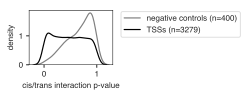

In [12]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(cis_trans_int[cis_trans_int["ctrl_status"] == "control"]["pval"], hist=False, color="gray",
             label="negative controls (n=%s)" % len(cis_trans_int[cis_trans_int["ctrl_status"] == "control"]))
sns.distplot(cis_trans_int[cis_trans_int["ctrl_status"] != "control"]["pval"], hist=False, color="black",
             label="TSSs (n=%s)" % len(cis_trans_int[cis_trans_int["ctrl_status"] != "control"]))

plt.ylabel("density")
plt.xlabel("cis/trans interaction p-value")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("cis_trans_int_ctrl_pval_dist.pdf", dpi="figure", bbox_inches="tight")

In [13]:
cis_trans_int["abs_logFC"] = np.abs(cis_trans_int["logFC"])

In [14]:
order = ["control", "TSS"]
pal = {"control": "gray", "TSS": "black"}

2.68587697663e-58


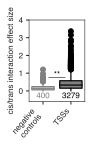

In [15]:
fig = plt.figure(figsize=(1, 1.5))
ax = sns.boxplot(data=cis_trans_int, x="ctrl_status", y="abs_logFC", flierprops = dict(marker='o', markersize=5), 
                 order=order, palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["negative\ncontrols", "TSSs"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("cis/trans interaction effect size")

for i, label in enumerate(order):
    n = len(cis_trans_int[cis_trans_int["ctrl_status"] == label])
    color = pal[label]
    ax.annotate(str(n), xy=(i, -0.5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.6, 4))

# calc p-vals b/w dists
dist1 = np.asarray(cis_trans_int[cis_trans_int["ctrl_status"] == "control"]["abs_logFC"])
dist2 = np.asarray(cis_trans_int[cis_trans_int["ctrl_status"] != "control"]["abs_logFC"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 0.77, 0, 0.7, pval, fontsize)
fig.savefig("cis_trans_int_ctrl_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 3. classify cis/trans interaction effects

In [16]:
cis_trans_int["cis_trans_int_status"] = cis_trans_int.apply(cis_trans_int_status, axis=1)
cis_trans_int.cis_trans_int_status.value_counts()

no cis/trans interaction             3647
significant cis/trans interaction      32
Name: cis_trans_int_status, dtype: int64

In [17]:
cis_trans_int[cis_trans_int["cis_trans_int_status"].str.contains("significant")]

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,ctrl_status,abs_logFC,cis_trans_int_status
54,h.58__div_lnc__m.37__div_lnc,11.230470,8.046525e-04,0.095494,1,14,9,8,1.558644,TSS,1.558644,significant cis/trans interaction
1020,h.1148__enhancer__m.1020__enhancer,11.128098,8.502972e-04,0.097758,1,14,9,8,1.529204,TSS,1.529204,significant cis/trans interaction
1275,h.1280__enhancer__m.1152__enhancer,11.634119,6.475301e-04,0.091626,1,14,9,8,1.625182,TSS,1.625182,significant cis/trans interaction
1305,h.1485__enhancer__m.1310__enhancer,11.411207,7.300239e-04,0.092612,1,14,9,8,-1.467205,TSS,1.467205,significant cis/trans interaction
1323,h.1305__enhancer__m.1177__enhancer,28.690043,8.493932e-08,0.000312,1,14,9,8,1.661667,TSS,1.661667,significant cis/trans interaction
1324,h.1495__enhancer__m.1177__enhancer,17.059617,3.622446e-05,0.014617,1,14,9,8,1.485331,TSS,1.485331,significant cis/trans interaction
1390,h.1534__antisense__m.1346__no cage activity,22.096546,2.592759e-06,0.001908,1,14,9,8,1.652141,TSS,1.652141,significant cis/trans interaction
1399,h.1543__antisense_upep__m.1355__no cage activity,26.187557,3.098124e-07,0.000486,1,14,9,8,2.489324,TSS,2.489324,significant cis/trans interaction
1411,h.1555__antisense_upep__m.1367__no cage activity,25.710505,3.966620e-07,0.000486,1,14,9,8,2.040195,TSS,2.040195,significant cis/trans interaction
1474,h.1627__antisense__m.1439__no cage activity,16.884246,3.972997e-05,0.014617,1,14,9,8,2.765681,TSS,2.765681,significant cis/trans interaction


In [18]:
results[(results["hg19_id"] == "h.1305") & (results["mm9_id"] == "m.1177")][["logFC_cis_HUES64", "logFC_cis_mESC"]]

,logFC_cis_HUES64,logFC_cis_mESC
1325,-1.249232,0.397936


In [19]:
results[(results["hg19_id"] == "h.2113") & (results["mm9_id"] == "m.1925")][["logFC_cis_HUES64", "logFC_cis_mESC"]]

,logFC_cis_HUES64,logFC_cis_mESC
1892,0.705418,-0.66484


almost all significant examples are ones where the mouse seq. does not work in human but then does [better] in mouse -- these have a logFC > 0. why are there so few examples of the opposite?

## 4. merge w/ existing data

In [20]:
cis_trans_int["hg19_id"] = cis_trans_int["index"].str.split("__", expand=True)[0]
cis_trans_int["biotype_hg19"] = cis_trans_int["index"].str.split("__", expand=True)[1]
cis_trans_int["mm9_id"] = cis_trans_int["index"].str.split("__", expand=True)[2]
cis_trans_int["biotype_mm9"] = cis_trans_int["index"].str.split("__", expand=True)[3]
cis_trans_int.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,ctrl_status,abs_logFC,cis_trans_int_status,hg19_id,biotype_hg19,mm9_id,biotype_mm9
0,h.2__div_lnc__m.1__div_lnc,0.143043,0.705274,0.998780,1,14,9,8,-0.182773,TSS,0.182773,no cis/trans interaction,h.2,div_lnc,m.1,div_lnc
1,h.3__div_lnc__m.2__antisense,2.049746,0.152232,0.844449,1,13,9,8,-1.070741,TSS,1.070741,no cis/trans interaction,h.3,div_lnc,m.2,antisense
2,h.4__antisense_upep__m.3__protein_coding,2.357665,0.124669,0.794898,1,14,9,8,-0.596464,TSS,0.596464,no cis/trans interaction,h.4,antisense_upep,m.3,protein_coding
3,h.5__intergenic__m.4__intergenic_upep,0.344383,0.557310,0.998124,1,14,9,8,0.204346,TSS,0.204346,no cis/trans interaction,h.5,intergenic,m.4,intergenic_upep
4,h.6__intergenic__m.4__intergenic_upep,0.476053,0.490215,0.985916,1,14,9,8,0.232479,TSS,0.232479,no cis/trans interaction,h.6,intergenic,m.4,intergenic_upep


In [21]:
cis_trans_int_sub = cis_trans_int[["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr", "logFC", "abs_logFC",
                                   "cis_trans_int_status"]]
cis_trans_int_sub.columns = ["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr_cis_trans_int", 
                             "logFC_cis_trans_int", "abs_logFC_cis_trans_int", "cis_trans_int_status"]

In [22]:
data = results.merge(cis_trans_int_sub, 
                     left_on=["hg19_id", "biotype_hg19", 
                              "mm9_id", "biotype_mm9"], 
                     right_on=["hg19_id", "biotype_hg19", 
                               "mm9_id", "biotype_mm9"])
print(len(data))
data.sample(5)

3279


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,trans_status_mouse,trans_status_detail_mouse,trans_status_one,trans_status_detail_one,logFC_trans_max,abs_logFC_trans_max,fdr_cis_trans_int,logFC_cis_trans_int,abs_logFC_cis_trans_int,cis_trans_int_status
798,chr1,101491339,101491340,-,"chr1:101491323..101491355,-",div_pc,ENSG00000117543.15,True,True,chr3,...,no trans effect,no trans effect,no trans effect,no trans effect,-0.418018,0.418018,0.998780,0.311570,0.311570,no cis/trans interaction
1642,chr11,118401855,118401856,-,"chr11:118401816..118401871,-",div_upep,ENSG00000255435.2,True,False,chr9,...,no trans effect,no trans effect,no trans effect,no trans effect,-0.669517,0.669517,0.985916,0.386634,0.386634,no cis/trans interaction
2432,chr20,35089553,35089554,-,no cage activity,no cage activity,no cage activity,True,False,chr2,...,no trans effect,no trans effect,no trans effect,no trans effect,0.443604,0.443604,0.813999,-0.990782,0.990782,no cis/trans interaction
2187,chr17,36008830,36008831,+,chr17:36008623-36009017,enhancer,chr17:36008623-36009017__POSITIVE,True,False,chr11,...,no trans effect,no trans effect,no trans effect,no trans effect,0.444169,0.444169,0.998780,-0.123842,0.123842,no cis/trans interaction
831,chr12,80328708,80328709,-,"chr12:80328700..80328751,-",div_pc,ENSG00000058272.11,True,True,chr10,...,no trans effect,no trans effect,no trans effect,no trans effect,-0.514132,0.514132,0.998780,0.159109,0.159109,no cis/trans interaction


In [23]:
# limit to those that are significant in at least 1 context
data_filt = data[(data["HUES64_padj_hg19"] < 0.05) | (data["mESC_padj_mm9"] < 0.05)]
len(data_filt)

1832

In [25]:
data_filt.cis_trans_int_status.value_counts()

no cis/trans interaction             1803
significant cis/trans interaction      29
Name: cis_trans_int_status, dtype: int64

## 5. model

In [55]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [50]:
full_mod = smf.ols(formula='logFC_native ~ logFC_cis_max + logFC_trans_max + logFC_cis_max : logFC_trans_max', 
                   data=data_filt).fit()
cis_mod = smf.ols(formula='logFC_native ~ logFC_cis_max', 
                  data=data_filt).fit()
trans_mod = smf.ols(formula='logFC_native ~ logFC_trans_max', 
                    data=data_filt).fit()
no_inter_mod = smf.ols(formula='logFC_native ~ logFC_cis_max + logFC_trans_max', 
                       data=data_filt).fit()

In [51]:
# cis model alone
cis_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logFC_native   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 1.534e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:54:48   Log-Likelihood:                -1031.8
No. Observations:                1832   AIC:                             2068.
Df Residuals:                    1830   BIC:                             2079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0353      0.010      3.556      0.000       0.016       0.055
logFC_cis_max     0.8451      0.007    123.860      0.000       0.832       0.858
==============================================================================
Omnibus:                       72.677   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.265
Skew:                          -0.275   Prob(JB):                     7.77e-32
Kurtosis:                       4.255   Cond. No.                         1.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# trans model alone
trans_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logFC_native   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     125.5
Date:                Mon, 10 Jun 2019   Prob (F-statistic):           3.19e-28
Time:                        15:54:58   Log-Likelihood:                -3021.9
No. Observations:                1832   AIC:                             6048.
Df Residuals:                    1830   BIC:                             6059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0958      0.029      3.251      0.001       0.038       0.154
logFC_trans_max     0.5786      0.052     11.203      0.000       0.477       0.680
==============================================================================
Omnibus:                       44.040   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.859
Skew:                           0.260   Prob(JB):                     3.69e-14
Kurtosis:                       3.734   Cond. No.                         1.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# cis and trans mod together
no_inter_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logFC_native   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 2.048e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:55:59   Log-Likelihood:                -194.89
No. Observations:                1832   AIC:                             395.8
Df Residuals:                    1829   BIC:                             412.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0530      0.006      8.408      0.000       0.041       0.065
logFC_cis_max       0.8449      0.004    195.486      0.000       0.836       0.853
logFC_trans_max     0.5771      0.011     52.262      0.000       0.555       0.599
==============================================================================
Omnibus:                       71.025   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.881
Skew:                           0.100   Prob(JB):                     1.07e-43
Kurtosis:                       4.598   Cond. No.                         2.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
full_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logFC_native   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.389e+04
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:02:59   Log-Likelihood:                -179.13
No. Observations:                1832   AIC:                             366.3
Df Residuals:                    1828   BIC:                             388.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0527      0.006      8.420      0.000       0.040       0.065
logFC_cis_max                     0.8496      0.004    194.589      0.000       0.841       0.858
logFC_trans_max                   0.5719      0.011     52.055      0.000       0.550       0.593
logFC_cis_max:logFC_trans_max     0.0323      0.006      5.634      0.000       0.021       0.044
==============================================================================
Omnibus:                       69.118   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.438
Skew:                          -0.051   Prob(JB):                     1.34e-43
Kurtosis:                       4.605   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

In [60]:
# does adding trans info help cis model?
cisllf = cis_mod.llf
cistransllf = no_inter_mod.llf
lr, p = lrtest(cisllf, cistransllf)
print('LR test, p value: {:.2f}, {:.10f}'.format(lr, p))

LR test, p value: 1673.76, 0.0000000000


In [61]:
# does adding cis-trans info help model?
cistransllf = no_inter_mod.llf
cistransinterllf = inter_mod.llf
lr, p = lrtest(cistransllf, cistransinterllf)
print('LR test, p value: {:.2f}, {:.10f}'.format(lr, p))

LR test, p value: -5743.05, 1.0000000000


In [69]:
df = full_mod.conf_int(alpha=0.05, cols=None)
df["estimate"] = list(full_mod.params)
df = df.reset_index()
df

,index,0,1,estimate
0,Intercept,0.040394,0.064925,0.052659
1,logFC_cis_max,0.841023,0.858149,0.849586
2,logFC_trans_max,0.550395,0.593493,0.571944
3,logFC_cis_max:logFC_trans_max,0.021041,0.043515,0.032278


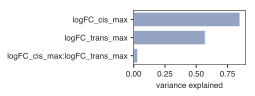

In [73]:
fig = plt.figure(figsize=(2, 1))

ax = sns.barplot(data=df[df["index"] != "Intercept"], y="index", x="estimate", color=sns.color_palette("Set2")[2])

ax.set_xlabel("variance explained")
ax.set_ylabel("")

In [76]:
cis_mod.rsquared

0.89342651824400332

In [77]:
no_inter_mod.rsquared

0.95725676143476324

In [75]:
full_mod.rsquared

0.95798618116318557

In [80]:
cis_var = cis_mod.rsquared
cis_var

0.89342651824400332

In [81]:
trans_var = no_inter_mod.rsquared - cis_var
trans_var

0.063830243190759917

In [83]:
int_var = full_mod.rsquared - no_inter_mod.rsquared
int_var

0.00072941972842233138